In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics

from xgboost import XGBClassifier


from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    
    precision=precision_score(Y_test,y_pred_test)
    recall=recall_score(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc,precision,recall
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

# def Logistic_model(X_train,Y_train,X_test,Y_test):
#     print('\033[1m' + 'Logistic Regression' + '\033[0m')
#     log=LogisticRegression()
#     log.fit(X_train,Y_train)
    
#     return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def XGB(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'XGB Classifier' + '\033[0m')
    xgb=XGBClassifier(random_state=0)
    xgb.fit(X_train,Y_train)
    
    return model_build(xgb,X_train,Y_train,X_test,Y_test,True,feat)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    precision=precision_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    recall=recall_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,precision,recall

In [4]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)
Shape of URL dataset: (46771, 4194)


In [5]:
df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [6]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.c',
 'url_extension_.com',
 'url_extension_endswith_.com',
 'url_extensions',
 'url_length',
 'Target']

print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.c',
 'url_extension_.com',
 'url_extension_endswith_.com',
 'url_extensions',
 'url_length',
 'Target']

In [7]:
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)

### <a id='1' style="text-decoration : none; color : #000000;"> 1. Initial Models</a>

In [8]:
df_sel=df[columns].copy(deep=True)

train=df_sel.iloc[:27428,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[27428:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)
columns.remove('Target')

ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9817339944582179
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24195   132    24327
True         369  2732     3101
__all__    24564  2864    27428

Accuracy of the model for test data is: 0.9756699276903446
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10338    77    10415
True         209  1131     1340
__all__    10547  1208    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9969738952894852
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24315    12    24327
True          71  3030     3101
__all__    24386  3042    27428

Accuracy of the model for test data is: 0.980093577201191
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10363    52    10415
True         182  1158     1340
__all__    10545  1210    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9726556803266735
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      23997   330    24327
True         420  2681     3101
__all__    24417  3011    27428

Accuracy of the model for test data is: 0.9706507868991918
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10267   148    10415
True         197  1143     1340
__all__    10464  1291    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9804214671138982
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24187   140    24327
True         397  2704     3101
__all__    24584  2844    27428

Accuracy of the model for test data is: 0.976860910250957
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10340    75    10415
True         197  1143     1340
__all__    10537  1218    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9985416362840892
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24324     3    24327
True          37  3064     3101
__all__    24361  3067    27428

Accuracy of the model for test data is: 0.9796682262866865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10362    53    10415
True         186  1154     1340
__all__    10548  1207    11755



XGB Classifier
Accuracy of the model for training data is: 0.9795464488843517
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24188   139    24327
True         422  2679     3101
__all__    24610  2818    27428

Accuracy of the model for test data is: 0.9754147171416419
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10335    80    10415
True         209  1131     1340
__all__    10544  1211    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9967186816392009
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24314    13    24327
True          77  3024     3101
__all__    24391  3037    27428

Accuracy of the model for test data is: 0.9779668226286686
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10343    72    10415
True         187  1153     1340
__all__    10530  1225    11755



Neural Network-1
The accuracy of the model on training data is: 0.9940571678576637


Predicted  False  True  __all__
Actual                         
False      24269    58    24327
True         105  2996     3101
__all__    24374  3054    27428

The accuracy of the model on test data is: 0.9757549978732454


Predicted  False  True  __all__
Actual                         
False      10304   111    10415
True         174  1166     1340
__all__    10478  1277    11755

### <a id='1.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [9]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [10]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.981734,2732.0,24195.0,132.0,369.0,0.005426,0.118994
RandomForestClassifier,0.996974,3030.0,24315.0,12.0,71.0,0.000493,0.022896
AdaBoostClassifier,0.972656,2681.0,23997.0,330.0,420.0,0.013565,0.135440
GradientBoostingClassifier,0.980421,2704.0,24187.0,140.0,397.0,0.005755,0.128023
ExtraTreeClassifier,0.998542,3064.0,24324.0,3.0,37.0,0.000123,0.011932
XGB,0.979546,2679.0,24188.0,139.0,422.0,0.005714,0.136085
BaggingClassifier,0.996719,3024.0,24314.0,13.0,77.0,0.000534,0.024831
Neural Network-1,0.994057,2996.0,24269.0,58.0,105.0,0.002384,0.033860


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.975670,1131.0,10338.0,77.0,209.0,0.007393,0.155970,0.918318,0.875631,0.936258,0.844030
RandomForestClassifier,0.980094,1158.0,10363.0,52.0,182.0,0.004993,0.135821,0.929593,0.898573,0.957025,0.864179
AdaBoostClassifier,0.970651,1143.0,10267.0,148.0,197.0,0.014210,0.147015,0.919387,0.852541,0.885360,0.852985
GradientBoostingClassifier,0.976861,1143.0,10340.0,75.0,197.0,0.007201,0.147015,0.922892,0.881981,0.938424,0.852985
ExtraTreeClassifier,0.979668,1154.0,10362.0,53.0,186.0,0.005089,0.138806,0.928053,0.896335,0.956089,0.861194
XGB,0.975415,1131.0,10335.0,80.0,209.0,0.007681,0.155970,0.918174,0.874369,0.933939,0.844030
BaggingClassifier,0.977967,1153.0,10343.0,72.0,187.0,0.006913,0.139552,0.926767,0.887812,0.941224,0.860448
Neural Network-1,0.975755,1166.0,10304.0,111.0,174.0,0.010658,0.129851,0.926767,0.877787,0.913078,0.870149


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [12]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [13]:
sm = SMOTE(random_state=12, ratio = {1:24327})
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)


ind_columns=['KNeighborsClassifier','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','XGB','BaggingClassifier','Neural Network-1']

f=[KNN_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,XGB,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9822419533851277
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23557    770    24327
True          94  24233    24327
__all__    23651  25003    48654

Accuracy of the model for test data is: 0.9487877498936623
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9943   472    10415
True         130  1210     1340
__all__    10073  1682    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.998520162782094
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24309     18    24327
True          54  24273    24327
__all__    24363  24291    48654

Accuracy of the model for test data is: 0.9789876648234793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10333    82    10415
True         165  1175     1340
__all__    10498  1257    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.956776421260328
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23196   1131    24327
True         972  23355    24327
__all__    24168  24486    48654

Accuracy of the model for test data is: 0.9508294342832837
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9938   477    10415
True         101  1239     1340
__all__    10039  1716    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9727874378262835
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23673    654    24327
True         670  23657    24327
__all__    24343  24311    48654

Accuracy of the model for test data is: 0.9638451722671204
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10111   304    10415
True         121  1219     1340
__all__    10232  1523    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9991778682122744
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24324      3    24327
True          37  24290    24327
__all__    24361  24293    48654

Accuracy of the model for test data is: 0.9796682262866865
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10338    77    10415
True         162  1178     1340
__all__    10500  1255    11755



XGB Classifier
Accuracy of the model for training data is: 0.9718625395650923
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23648    679    24327
True         690  23637    24327
__all__    24338  24316    48654

Accuracy of the model for test data is: 0.963419821352616
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10109   306    10415
True         124  1216     1340
__all__    10233  1522    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9982940765404694
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24302     25    24327
True          58  24269    24327
__all__    24360  24294    48654

Accuracy of the model for test data is: 0.9730327520204168
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10280   135    10415
True         182  1158     1340
__all__    10462  1293    11755



Neural Network-1
The accuracy of the model on training data is: 0.9927857935627081


Predicted  False   True  __all__
Actual                          
False      24041    286    24327
True          65  24262    24327
__all__    24106  24548    48654

The accuracy of the model on test data is: 0.9648660144619311


Predicted  False  True  __all__
Actual                         
False      10141   274    10415
True         139  1201     1340
__all__    10280  1475    11755

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [14]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [15]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.982242,24233.0,23557.0,770.0,94.0,0.031652,0.003864
RandomForestClassifier,0.998520,24273.0,24309.0,18.0,54.0,0.000740,0.002220
AdaBoostClassifier,0.956776,23355.0,23196.0,1131.0,972.0,0.046492,0.039956
GradientBoostingClassifier,0.972787,23657.0,23673.0,654.0,670.0,0.026884,0.027541
ExtraTreeClassifier,0.999178,24290.0,24324.0,3.0,37.0,0.000123,0.001521
XGB,0.971863,23637.0,23648.0,679.0,690.0,0.027911,0.028364
BaggingClassifier,0.998294,24269.0,24302.0,25.0,58.0,0.001028,0.002384
Neural Network-1,0.992786,24262.0,24041.0,286.0,65.0,0.011756,0.002672


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.948788,1210.0,9943.0,472.0,130.0,0.045319,0.097015,0.928833,0.778409,0.719382,0.902985
RandomForestClassifier,0.978988,1175.0,10333.0,82.0,165.0,0.007873,0.123134,0.934496,0.893670,0.934765,0.876866
AdaBoostClassifier,0.950829,1239.0,9938.0,477.0,101.0,0.045799,0.075373,0.939414,0.791010,0.722028,0.924627
GradientBoostingClassifier,0.963845,1219.0,10111.0,304.0,121.0,0.029189,0.090299,0.940256,0.833273,0.800394,0.909701
ExtraTreeClassifier,0.979668,1178.0,10338.0,77.0,162.0,0.007393,0.120896,0.935856,0.897095,0.938645,0.879104
XGB,0.963420,1216.0,10109.0,306.0,124.0,0.029381,0.092537,0.939041,0.831205,0.798949,0.907463
BaggingClassifier,0.973033,1158.0,10280.0,135.0,182.0,0.012962,0.135821,0.925609,0.864601,0.895592,0.864179
Neural Network-1,0.964866,1201.0,10141.0,274.0,139.0,0.026308,0.103731,0.925609,0.834620,0.814237,0.896269


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [16]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;">3. UnderSampling </a>

In [18]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

Shape after undersampling (6202, 36)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.9496936472105773
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2962   139     3101
True         173  2928     3101
__all__     3135  3067     6202

Accuracy of the model for test data is: 0.9357720119098256
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9774   641    10415
True         114  1226     1340
__all__     9888  1867    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9948403740728797
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3092     9     3101
True          23  3078     3101
__all__     3115  3087     6202

Accuracy of the model for test data is: 0.9559336452573373
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9999   416    10415
True         102  1238     1340
__all__    10101  1654    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9440503063527894
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2930   171     3101
True         176  2925     3101
__all__     3106  3096     6202

Accuracy of the model for test data is: 0.943428328370906
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9839   576    10415
True          89  1251     1340
__all__     9928  1827    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9558207029990325
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2965   136     3101
True         138  2963     3101
__all__     3103  3099     6202

Accuracy of the model for test data is: 0.9509145044661846
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9922   493    10415
True          84  1256     1340
__all__    10006  1749    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9980651402773298
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3101     0     3101
True          12  3089     3101
__all__     3113  3089     6202

Accuracy of the model for test data is: 0.9590812420246704
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10043   372    10415
True         109  1231     1340
__all__    10152  1603    11755



XGB Classifier
Accuracy of the model for training data is: 0.9525959367945824
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       2965   136     3101
True         158  2943     3101
__all__     3123  3079     6202

Accuracy of the model for test data is: 0.9538919608677159
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9959   456    10415
True          86  1254     1340
__all__    10045  1710    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9941954208319896
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3091    10     3101
True          26  3075     3101
__all__     3117  3085     6202

Accuracy of the model for test data is: 0.953806890684815
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       9980   435    10415
True         108  1232     1340
__all__    10088  1667    11755



Neural Network-1
The accuracy of the model on training data is: 0.990809416317317


Predicted  False  True  __all__
Actual                         
False       3093     8     3101
True          49  3052     3101
__all__     3142  3060     6202

The accuracy of the model on test data is: 0.9549978732454275


Predicted  False  True  __all__
Actual                         
False      10015   400    10415
True         129  1211     1340
__all__    10144  1611    11755

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [20]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [21]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.949694,2928.0,2962.0,139.0,173.0,0.044824,0.055788
RandomForestClassifier,0.994840,3078.0,3092.0,9.0,23.0,0.002902,0.007417
AdaBoostClassifier,0.944050,2925.0,2930.0,171.0,176.0,0.055144,0.056756
GradientBoostingClassifier,0.955821,2963.0,2965.0,136.0,138.0,0.043857,0.044502
ExtraTreeClassifier,0.998065,3089.0,3101.0,0.0,12.0,0.000000,0.003870
XGB,0.952596,2943.0,2965.0,136.0,158.0,0.043857,0.050951
BaggingClassifier,0.994195,3075.0,3091.0,10.0,26.0,0.003225,0.008384
Neural Network-1,0.990809,3052.0,3093.0,8.0,49.0,0.002580,0.015801


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.935772,1226.0,9774.0,641.0,114.0,0.061546,0.085075,0.926690,0.741990,0.656668,0.914925
RandomForestClassifier,0.955934,1238.0,9999.0,416.0,102.0,0.039942,0.076119,0.941969,0.807893,0.748489,0.923881
AdaBoostClassifier,0.943428,1251.0,9839.0,576.0,89.0,0.055305,0.066418,0.939139,0.770395,0.684729,0.933582
GradientBoostingClassifier,0.950915,1256.0,9922.0,493.0,84.0,0.047336,0.062687,0.944989,0.794760,0.718125,0.937313
ExtraTreeClassifier,0.959081,1231.0,10043.0,372.0,109.0,0.035718,0.081343,0.941470,0.817655,0.767935,0.918657
XGB,0.953892,1254.0,9959.0,456.0,86.0,0.043783,0.064179,0.946019,0.804067,0.733333,0.935821
BaggingClassifier,0.953807,1232.0,9980.0,435.0,108.0,0.041767,0.080597,0.938818,0.799514,0.739052,0.919403
Neural Network-1,0.954998,1211.0,10015.0,400.0,129.0,0.038406,0.096269,0.938818,0.799667,0.751707,0.903731


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [22]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [23]:
df.reset_index(inplace=True)
columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2556 features
EntitySet scattered to workers in 4.533 seconds
Elapsed: 00:15 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [24]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [25]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y)

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()

In [26]:
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [27]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)
print('Features we will be using:\n')
display(feature_name)

The train/test split ratio is 70:30
Features we will be using:



['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_y',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_z + url_extensions',
 'url_char_y + url_extensions',
 'url_char_y * url_extensions',
 'url_char_w + url_extensions',
 'url_char_w + url_char_z',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_i / total_count',
 'url_char_f + url_extensions',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_f',
 'url_char_. * url_char_w',
 'http_header_vary_user-agent + url_extensions',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_extensions',
 'a_href_relative / total_href',
 'a_href_relative / a_count',
 'a_href_out_of_domain / total_href']

In [28]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:27428]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[27428:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9783432988187254
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24155   172    24327
True         422  2679     3101
__all__    24577  2851    27428

Accuracy of the model for test data is: 0.9703955763504891
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10315   100    10415
True         248  1092     1340
__all__    10563  1192    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9934738223712994
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24281    46    24327
True         133  2968     3101
__all__    24414  3014    27428

Accuracy of the model for test data is: 0.973713313483624
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10312   103    10415
True         206  1134     1340
__all__    10518  1237    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9723640075834913
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24061   266    24327
True         492  2609     3101
__all__    24553  2875    27428

Accuracy of the model for test data is: 0.9679285410463633
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10279   136    10415
True         241  1099     1340
__all__    10520  1235    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9797287443488406
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24191   136    24327
True         420  2681     3101
__all__    24611  2817    27428

Accuracy of the model for test data is: 0.9738834538494258
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10331    84    10415
True         223  1117     1340
__all__    10554  1201    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.99558844975937
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24311    16    24327
True         105  2996     3101
__all__    24416  3012    27428

Accuracy of the model for test data is: 0.973713313483624
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10314   101    10415
True         208  1132     1340
__all__    10522  1233    11755



XGB Classifier
Accuracy of the model for training data is: 0.978416217004521
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24194   133    24327
True         459  2642     3101
__all__    24653  2775    27428

Accuracy of the model for test data is: 0.9735431731178222
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10330    85    10415
True         226  1114     1340
__all__    10556  1199    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9934738223712994
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24274    53    24327
True         126  2975     3101
__all__    24400  3028    27428

Accuracy of the model for test data is: 0.973713313483624
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10305   110    10415
True         199  1141     1340
__all__    10504  1251    11755



Neural Network-1


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method

The accuracy of the model on training data is: 0.9840309173107773


Predicted  False  True  __all__
Actual                         
False      24228    99    24327
True         339  2762     3101
__all__    24567  2861    27428

The accuracy of the model on test data is: 0.9730327520204168


Predicted  False  True  __all__
Actual                         
False      10308   107    10415
True         210  1130     1340
__all__    10518  1237    11755

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.978343,2679.0,24155.0,172.0,422.0,0.007070,0.136085
RandomForestClassifier,0.993474,2968.0,24281.0,46.0,133.0,0.001891,0.042889
AdaBoostClassifier,0.972364,2609.0,24061.0,266.0,492.0,0.010934,0.158658
GradientBoostingClassifier,0.979729,2681.0,24191.0,136.0,420.0,0.005590,0.135440
ExtraTreeClassifier,0.995588,2996.0,24311.0,16.0,105.0,0.000658,0.033860
XGB,0.978416,2642.0,24194.0,133.0,459.0,0.005467,0.148017
BaggingClassifier,0.993474,2975.0,24274.0,53.0,126.0,0.002179,0.040632
Neural Network-1,0.984031,2762.0,24228.0,99.0,339.0,0.004070,0.109320


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.970396,1092.0,10315.0,100.0,248.0,0.009602,0.185075,0.902662,0.847854,0.916107,0.814925
RandomForestClassifier,0.973713,1134.0,10312.0,103.0,206.0,0.009890,0.153731,0.918190,0.866231,0.916734,0.846269
AdaBoostClassifier,0.967929,1099.0,10279.0,136.0,241.0,0.013058,0.179851,0.903546,0.836495,0.889879,0.820149
GradientBoostingClassifier,0.973883,1117.0,10331.0,84.0,223.0,0.008065,0.166418,0.912758,0.866219,0.930058,0.833582
ExtraTreeClassifier,0.973713,1132.0,10314.0,101.0,208.0,0.009698,0.155224,0.917539,0.866121,0.918086,0.844776
XGB,0.973543,1114.0,10330.0,85.0,226.0,0.008161,0.168657,0.911591,0.864408,0.929108,0.831343
BaggingClassifier,0.973713,1141.0,10305.0,110.0,199.0,0.010562,0.148507,0.920465,0.866635,0.912070,0.851493
Neural Network-1,0.973033,1130.0,10308.0,107.0,210.0,0.010274,0.156716,0.920465,0.862742,0.913500,0.843284


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [31]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 104.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 104.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 104.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 104.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 104.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

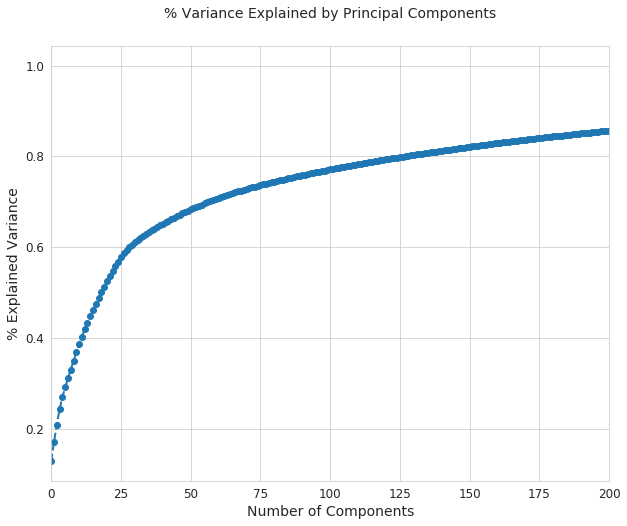

In [32]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [34]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.7970629745154557


In [35]:
X_train=X_pca_21[:27428]
Y_train=fs.iloc[:27428]['Target'].values
X_test=X_pca_21[27428:]
Y_test=fs.iloc[27428:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [37]:
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC','Precision','Recall'])

feat_imp=[None]*5
j=0
for i in range(0,8):
    if i>=1 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,125).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc,prec,rec=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc,prec,rec])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9816610762724224
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24231    96    24327
True         407  2694     3101
__all__    24638  2790    27428

Accuracy of the model for test data is: 0.9739685240323267
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10361    54    10415
True         252  1088     1340
__all__    10613  1142    11755



RandomForest Classifier
Accuracy of the model for training data is: 0.9961717952457343
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24316    11    24327
True          94  3007     3101
__all__    24410  3018    27428

Accuracy of the model for test data is: 0.9743938749468312
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10359    56    10415
True         245  1095     1340
__all__    10604  1151    11755



Adaoost Classifier
Accuracy of the model for training data is: 0.9732754849059355
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24055   272    24327
True         461  2640     3101
__all__    24516  2912    27428

Accuracy of the model for test data is: 0.9702254359846874
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10282   133    10415
True         217  1123     1340
__all__    10499  1256    11755



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9810412716931602
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24195   132    24327
True         388  2713     3101
__all__    24583  2845    27428

Accuracy of the model for test data is: 0.9740535942152275
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10323    92    10415
True         213  1127     1340
__all__    10536  1219    11755



ExtraTree Classifier
Accuracy of the model for training data is: 0.9985416362840892
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24324     3    24327
True          37  3064     3101
__all__    24361  3067    27428

Accuracy of the model for test data is: 0.9722671203743088
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10368    47    10415
True         279  1061     1340
__all__    10647  1108    11755



XGB Classifier
Accuracy of the model for training data is: 0.9807131398570803
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24192   135    24327
True         394  2707     3101
__all__    24586  2842    27428

Accuracy of the model for test data is: 0.9757549978732454
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10342    73    10415
True         212  1128     1340
__all__    10554  1201    11755



Bagging Classifier
Accuracy of the model for training data is: 0.9967915998249963
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24314    13    24327
True          75  3026     3101
__all__    24389  3039    27428

Accuracy of the model for test data is: 0.9746490854955339
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False      10327    88    10415
True         210  1130     1340
__all__    10537  1218    11755



Neural Network-1
The accuracy of the model on training data is: 0.9964634679889164


Predicted  False  True  __all__
Actual                         
False      24313    14    24327
True          83  3018     3101
__all__    24396  3032    27428

The accuracy of the model on test data is: 0.9772862611654615


Predicted  False  True  __all__
Actual                         
False      10315   100    10415
True         167  1173     1340
__all__    10482  1273    11755

In [38]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[0].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'KNN_model')


trace2 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[1].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[2].values[[0,7,8,9,10]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[3].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[4].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')


trace1 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[5].values[[0,7,8,9,10]],
                    mode = 'lines+markers',
                    name = 'XGB')


trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[6].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,7,8,9,10]],
                    y=table_80_50_test.iloc[7].values[[0,7,8,9,10]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [39]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.981661,2694.0,24231.0,96.0,407.0,0.003946,0.131248
RandomForestClassifier,0.996172,3007.0,24316.0,11.0,94.0,0.000452,0.030313
AdaBoostClassifier,0.973275,2640.0,24055.0,272.0,461.0,0.011181,0.148662
GradientBoostingClassifier,0.981041,2713.0,24195.0,132.0,388.0,0.005426,0.125121
ExtraTreeClassifier,0.998542,3064.0,24324.0,3.0,37.0,0.000123,0.011932
XGB,0.980713,2707.0,24192.0,135.0,394.0,0.005549,0.127056
BaggingClassifier,0.996792,3026.0,24314.0,13.0,75.0,0.000534,0.024186
Neural Network-1,0.996463,3018.0,24313.0,14.0,83.0,0.000575,0.026766


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC,Precision,Recall
index,,,,,,,,,,,
KNeighborsClassifier,0.973969,1088.0,10361.0,54.0,252.0,0.005185,0.188060,0.903378,0.865709,0.952715,0.811940
RandomForestClassifier,0.974394,1095.0,10359.0,56.0,245.0,0.005377,0.182836,0.905894,0.868064,0.951347,0.817164
AdaBoostClassifier,0.970225,1123.0,10282.0,133.0,217.0,0.012770,0.161940,0.912645,0.849023,0.894108,0.838060
GradientBoostingClassifier,0.974054,1127.0,10323.0,92.0,213.0,0.008833,0.158955,0.916106,0.867513,0.924528,0.841045
ExtraTreeClassifier,0.972267,1061.0,10368.0,47.0,279.0,0.004513,0.208209,0.893639,0.856302,0.957581,0.791791
XGB,0.975755,1128.0,10342.0,73.0,212.0,0.007009,0.158209,0.917391,0.875941,0.939217,0.841791
BaggingClassifier,0.974649,1130.0,10327.0,88.0,210.0,0.008449,0.156716,0.917417,0.870563,0.927750,0.843284
Neural Network-1,0.977286,1173.0,10315.0,100.0,167.0,0.009602,0.124627,0.917417,0.885420,0.921445,0.875373


In [40]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')